# 1: Filter NeverWorld2 data using diffusion-based filters

In [29]:
filter_fac = 32
end_time = 2900 
bleck = True
lorenz = True

In [2]:
import numpy as np
import xarray as xr
import dask

In [25]:
gpu = False

## Get a view of Neverworld2 data

In [5]:
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'
run = 'nw2_0.03125deg_N15_baseline_hmix20'
chunks = {'time': 1, 'zl':1}
nr_days = 100

st = xr.open_dataset('%s/%s/static.nc' % (path,run), decode_times=False)
sn = xr.open_dataset('%s/%s/snapshots_%08d.nc' % (path, run, end_time-nr_days+5), decode_times=False, chunks=chunks)
av = xr.open_dataset('%s/%s/averages_%08d.nc' % (path, run, end_time-nr_days+2), decode_times=False, chunks=chunks)

In [6]:
sn.time

<xarray.DataArray 'time' (time: 20)>
array([2805., 2810., 2815., 2820., 2825., 2830., 2835., 2840., 2845., 2850.,
       2855., 2860., 2865., 2870., 2875., 2880., 2885., 2890., 2895., 2900.])
Coordinates:
  * time     (time) float64 2.805e+03 2.81e+03 2.815e+03 ... 2.895e+03 2.9e+03
Attributes:
    long_name:       time
    units:           days since 0001-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   THIRTY_DAY_MONTHS
    calendar:        THIRTY_DAY_MONTHS

In [6]:
av.time

<xarray.DataArray 'time' (time: 20)>
array([2802.5, 2807.5, 2812.5, 2817.5, 2822.5, 2827.5, 2832.5, 2837.5, 2842.5,
       2847.5, 2852.5, 2857.5, 2862.5, 2867.5, 2872.5, 2877.5, 2882.5, 2887.5,
       2892.5, 2897.5])
Coordinates:
  * time     (time) float64 2.802e+03 2.808e+03 ... 2.892e+03 2.898e+03
Attributes:
    long_name:       time
    units:           days since 0001-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   THIRTY_DAY_MONTHS
    calendar:        THIRTY_DAY_MONTHS
    bounds:          time_bnds

Some missing 5-day average diagnostics are computed from snapshots. Since the snapshots time steps in `sn` are taken at the *end* of the 5-day average windows in `av` (see above), we can try and see if we have snapshot data for the 100 previous days, to be able to recover average data for the *first* 5-day window.

In [7]:
previous_sn_file = '%s/%s/snapshots_%08d.nc' % (path, run, end_time-2*nr_days+5)
from os.path import exists
if exists(previous_sn_file):
    sn_previous = xr.open_dataset(previous_sn_file, decode_times=False, chunks=chunks)
    previous = True
else: 
    previous = False
previous

True

In [8]:
sn_previous.time

<xarray.DataArray 'time' (time: 20)>
array([2705., 2710., 2715., 2720., 2725., 2730., 2735., 2740., 2745., 2750.,
       2755., 2760., 2765., 2770., 2775., 2780., 2785., 2790., 2795., 2800.])
Coordinates:
  * time     (time) float64 2.705e+03 2.71e+03 2.715e+03 ... 2.795e+03 2.8e+03
Attributes:
    long_name:       time
    units:           days since 0001-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   THIRTY_DAY_MONTHS
    calendar:        THIRTY_DAY_MONTHS

## Prepare NW2 grid information

In [15]:
from xgcm import Grid

Nx = np.size(st.xh)
Ny = np.size(st.yh)

# symmetric
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'},
            'Z': {'center': 'zl', 'outer': 'zi'} }

metrics = {('X',):['dxCu','dxCv','dxT','dxBu'],
           ('Y',):['dyCu','dyCv','dyT','dyBu']
          }

grid = Grid(st, coords=coords, periodic=['X'])

st['dxT'] = grid.interp(st.dxCu,'X')
st['dyT'] = grid.interp(st.dyCv,'Y', boundary='fill')
st['dxBu'] = grid.interp(st.dxCv,'X')
st['dyBu'] = grid.interp(st.dyCu,'Y',boundary='fill')

grid = Grid(st, coords=coords, periodic=['X'], metrics=metrics)

## Compute missing / additional diagnostics

### Compute thickness-weighted KE: $hKE = \frac{1}{2} h |\mathbf{u}|^2$

$hKE_n = h_n KE_n$, where $KE_n =\frac{1}{2}|\mathbf{u}_n|^2 $ is the kinetic energy density output by the model.

In [10]:
av['hKE'] = av['h'] * av['KE']
av['hKE'].attrs = {'units' : 'm3 s-2', 'long_name': 'thickness-weighted kinetic energy'}

sn['hKE'] = sn['h'] * sn['KE']
sn['hKE'].attrs = {'units' : 'm3 s-2', 'long_name': 'thickness-weighted kinetic energy'}

### Compute thickness tendencies
from continuity equation:
$$
\underbrace{\partial_t h}_\text{dhdt} = - \nabla\cdot(h\mathbf{u})
$$

In [11]:
uflux = grid.diff(av['uh'].fillna(value=0),'X')
vflux = grid.diff(av['vh'].fillna(value=0),'Y', boundary='fill')
dhdt = - (uflux + vflux) / st.area_t    
    
av['dhdt'] = dhdt.where(st.wet)
av['dhdt'].attrs = {'units' : 'm/s', 'long_name': 'Layer thickness tendency, computed from flux divergence'}
av['dhdt'] = av['dhdt'].chunk({'xh': Nx, 'yh': Ny})

### Compute $\eta, \eta^2, \partial_t\eta, \partial_t\eta^2$

$$
    \eta_k = -D + \sum_{i=k+1}^N h_i
$$

In [12]:
etaB = - st.depth_ocean
av['etaB'] = etaB.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
av['etaB'].attrs['long_name'] = 'Topographic height'

In [13]:
h_rev = av['h'].isel(zl=slice(None,None,-1))
eta = grid.cumsum(h_rev,'Z',boundary='fill')
eta = eta.isel(zi=slice(None,None,-1))
eta = eta + etaB
eta = eta.chunk({'zi':16})
eta = eta.transpose('time', 'zi', 'yh', 'xh') # reorder coordinates

av['eta'] = eta
av['eta'].attrs['long_name'] = 'Interface height'

av['eta2'] = av['eta']**2
av['eta2'].attrs['long_name'] = 'Interface height squared'

In [14]:
dhdt_rev = av['dhdt'].isel(zl=slice(None,None,-1))
deta_dt = grid.cumsum(dhdt_rev,'Z',boundary='fill')
deta_dt = deta_dt.isel(zi=slice(None,None,-1))
deta_dt = deta_dt.chunk({'zi':16})
deta_dt = xr.where(st.wet,deta_dt,np.nan)
deta_dt = deta_dt.transpose('time', 'zi', 'yh', 'xh') # reorder coordinates

av['deta_dt'] = deta_dt
av['deta_dt'].attrs['long_name'] = 'Tendency of interface height'

In [15]:
av['deta2_dt'] = 2 * av['eta'] * av['deta_dt']
av['deta2_dt'].attrs['long_name'] = 'Tendency of squared interface height'

### Compute $\eta, \eta^2$ for snapshots

In [16]:
if np.all(av.average_DT == av.average_DT[0]):
    deltat = av.average_DT[0] * 24 * 60 * 60
else: 
    raise AssertionError('averaging intervals vary')

h_rev = sn['h'].isel(zl=slice(None,None,-1))
eta = grid.cumsum(h_rev,'Z',boundary='fill')
eta = eta.isel(zi=slice(None,None,-1))
eta = eta + etaB

eta = xr.where(st.wet,eta,np.nan)
eta = eta.transpose('time', 'zi', 'yh', 'xh') # reorder coordinates

sn['eta'] = eta.copy()
sn['eta'].attrs['long_name'] = 'Interface height'

sn['eta2'] = sn['eta']**2
sn['eta2'].attrs['long_name'] = 'Interface height squared'

In [17]:
if np.array_equal(av.time_bnds[:,1],sn.time) :
    duhdt = sn['uh'] - sn['uh'].shift(time=1)
    duhdt = duhdt/deltat
    duhdt['time'] = av['uh'].time
    
    dvhdt = sn['vh'] - sn['vh'].shift(time=1)
    dvhdt = dvhdt/deltat
    dvhdt['time'] = av['vh'].time
else: 
    raise AssertionError('av and sn datasets not compatitble')

if doStep0 and sn_previous.time[-1].values == av.time_bnds[0,0].values:
    data = sn['uh'].isel(time=0) - sn_previous['uh'].isel(time=-1)
    data = (data/deltat)
    duhdt = xr.where(av.time==av.time[0], data, duhdt)  
    
    data = sn['vh'].isel(time=0) - sn_previous['vh'].isel(time=-1)
    data = (data/deltat)
    dvhdt = xr.where(av.time==av.time[0], data, dvhdt)  
else:
    doStep0 = 0
    
av['duhdt'] = duhdt.copy()
av['duhdt'].attrs = {'units' : 'm3 s-2', 'long_name': 'Zonal thickness flux tendency'}

av['dvhdt'] = dvhdt.copy()
av['dvhdt'].attrs = {'units' : 'm3 s-2', 'long_name': 'Meridional thickness flux tendency'}

NameError: name 'doStep0' is not defined

### Compute reduced gravity
$$
    g_k' = g (\rho_{k+1} - \rho_k) / \rho_o
$$

In [ ]:
rho_ref = 1000  # reference density in NeverWorld2
gprime = 10 * grid.diff(av.zl,'Z',boundary='fill') / rho_ref
gprime[15] = np.nan
print('$\prime{g}_0 = %g$' % (gprime[0]))
gprime.isel(zi=slice(1,15)).plot()

### Compute Montgomery potential
$$
    M_n = \sum_{k=0}^{n-1} g_k' \eta_k
$$

In [ ]:
MP = grid.cumsum(gprime * av['eta'],'Z')  # Montgomery potential
av['MP'] = MP.transpose('time', 'zl', 'yh', 'xh') # reorder coordinates
av['MP'].attrs = {'units' : 'm2 s-2', 'long_name': 'Montgomery potential'}

### Compute pressure flux divergence `uhM_div` = $\nabla\cdot(u_nh_nM_n)$

In [ ]:
# pressure flux
uhM = av['uh'] / st['dyCu'] * grid.interp(av['MP'].fillna(value=0), 'X', metric_weighted=['X','Y'])
uhM = uhM.chunk({'xq':Nx+1})

vhM = av['vh'] / st['dxCv'] * grid.interp(av['MP'].fillna(value=0),'Y', boundary='fill', metric_weighted=['X','Y'])
vhM = vhM.chunk({'yq':Ny+1})

# pressure flux divergence
uflux = grid.diff((uhM * st['dyCu']).fillna(value=0), 'X')
vflux = grid.diff((vhM * st['dxCv']).fillna(value=0), 'Y', boundary='fill')

av['uhM_div'] = (uflux + vflux) / st.area_t
av['uhM_div'].attrs = {'units' : ' m3 s-3', 'long_name': 'Pressure flux divergence'}

### Add up barotropic and baroclinic pressure term contributions

$$
\underbrace{- \sum_{i=1}^{k} g_{i-1/2}^\prime \nabla \eta_{i-1/2}}_\text{PFu+ u_BT_accel}
$$

In [ ]:
av['h_PFu']

In [ ]:
av['PFu+u_BT_accel'] = av['PFu'] + av['u_BT_accel']
av['PFu+u_BT_accel'].attrs = {'units' : 'm s-2', 'long_name': 'Zonal Pressure Force Acceleration (incl. barotropic anomaly)'}

av['PFu+u_BT_accel_visc_rem'] = av['PFu_visc_rem'] + av['u_BT_accel_visc_rem']
av['PFu+u_BT_accel_visc_rem'].attrs = {'units' : 'm s-2', 'long_name': 'Viscous remnant fraction of zonal Pressure Force Acceleration (incl. barotropic anomaly)'}

av['PFv+v_BT_accel'] = av['PFv'] + av['v_BT_accel']
av['PFv+v_BT_accel'].attrs = {'units' : 'm s-2', 'long_name': 'Meridional Pressure Force Acceleration (incl. barotropic anomaly)'}

av['PFv+v_BT_accel_visc_rem'] = av['PFv_visc_rem'] + av['v_BT_accel_visc_rem']
av['PFv+v_BT_accel_visc_rem'].attrs = {'units' : 'm s-2', 'long_name': 'Viscous remnant fraction of meridional Pressure Force Acceleration (incl. barotropic anomaly)'}

av['PE_to_KE+KE_BT'] = av['PE_to_KE'] + av['KE_BT']
av['PE_to_KE+KE_BT'].attrs = {'units' : 'm3 s-3', 'long_name': 'Potential to Kinetic Energy Conversion of Layer (incl. barotropic)'}

av['h_PFu+u_BT_accel'] = av['h_PFu'] + av['h_u_BT_accel']
av['h_PFu+u_BT_accel'].attrs = {'units' : 'm2 s-2', 'long_name': 'Thickness Multiplied Zonal Pressure Force Acceleration (incl. barotropic anomaly)'}

av['h_PFv+v_BT_accel'] = av['h_PFv'] + av['h_v_BT_accel']
av['h_PFv+v_BT_accel'].attrs = {'units' : 'm2 s-2', 'long_name': 'Thickness Multiplied Meridional Pressure Force Acceleration (incl. barotropic anomaly)'}


### Close visc-rem multiplied velocity budget (in exact manner)
Original momentum budget (zonal direction):
\begin{align}
    \underbrace{\frac{\partial \mathbf{u}_k}{\partial t}}_\text{dudt} + \underbrace{\left(\frac{{f} + {\zeta}_k}{h_k} \right) \hat{\mathbf{k}} \times \left( \mathbf{u}_k h_k \right) + \nabla K_k}_\text{- CAu} = \underbrace{- \sum_{i=1}^{k} g_{i-1/2}^\prime \nabla \eta_{i-1/2}}_\text{PFu+ u_BT_accel} + \underbrace{F_{hor}}_\text{diffu} + \underbrace{F_{vert}}_\text{du_dt_visc}
    \; 
    \label{eqn:u} \;,
\end{align}

The visc-rem multiplied velocity budget (in zonal direction) is given by

    dudt = CAu_visc_rem + PFv_visc_rem + u_BT_accel_visc_rem + diffu_visc_rem + du_dt_visc_rem  (*),
    
see https://github.com/ocean-eddy-cpt/MOM6/pull/10. The modified momentum budget (*)
1. filters out the balance between PFu and du_dt_visc in vanished layers,
2. leaves the momentum budget as is in non-vanished layers.

The first aspect is desirable when spatially filtering the terms on the right hand side of (*). In the unmodified budget, the filter will spread high PFu / du_dt_visc values from vanished layers into the interior ocean, which would contaminate the EKE budget. The problem is solved when the PFu / du_dt_visc balance is masked out in vanished layers from the get-go. Note that this problem only arises for non-TWA diagnostics.

The first 4 term on the right hand side of (*) are diagnostics of the model output, and the 5th term can be inferred by

    du_dt_visc_rem = dudt - CAu_visc_rem - PFv_visc_rem - u_BT_accel_visc_rem - diffu_visc_rem,
    
as done in the next cell.

In [ ]:
av['du_dt_visc_rem'] = av['dudt'] - av['CAu_visc_rem'] - av['PFu_visc_rem'] - av['u_BT_accel_visc_rem'] - av['diffu_visc_rem']
av['dv_dt_visc_rem'] = av['dvdt'] - av['CAv_visc_rem'] - av['PFv_visc_rem'] - av['v_BT_accel_visc_rem'] - av['diffv_visc_rem']
av['du_dt_visc_rem'].attrs = {'units' : 'm s-2', 'long_name': 'Viscous remnant fraction of zonal acceleration from vertical viscosity'}
av['dv_dt_visc_rem'].attrs = {'units' : 'm s-2', 'long_name': 'Viscous remnant fraction of zonal acceleration from vertical viscosity'}

# Filtering

In [30]:
import gcm_filters
if gpu:
    import cupy as cp
from dask.diagnostics import ProgressBar

### Transform symmetric data to non-symmetric data

In [17]:
av_orig = av.copy()
sn_orig = sn.copy()

In [18]:
av = av.astype(np.float64)  # to avoid numerical instability
sn = sn.astype(np.float64)  # to avoid numerical instability

In [19]:
av = av.isel(xq = slice(1,None), yq=slice(1,None))
sn = sn.isel(xq = slice(1,None), yq=slice(1,None))

### New datasets for filtered fields

In [20]:
# new xarray datasets for filtered fields
av_f_tmp = xr.Dataset() 
av_f = xr.Dataset()
sn_f_tmp = xr.Dataset() 
sn_f = xr.Dataset()

for dim in av.dims:
    av_f_tmp[dim] = av[dim]  # temporary dataset with non-symmetric dimensions
for dim in sn.dims:
    sn_f_tmp[dim] = sn[dim]  # temporary dataset with non-symmetric dimensions    
for dim in av_orig.dims:
    av_f[dim] = av_orig[dim]  # dataset with symmetric dimensions
for dim in sn_orig.dims:
    sn_f[dim] = sn_orig[dim]  # dataset with symmetric dimensions  
av_f['average_DT'] = av_orig['average_DT']
av_f['time_bnds'] = av_orig['time_bnds']

### Use Gaussian filter shape and simple fixed factor (see Grooms et al., 2021)

In [21]:
filter_shape = gcm_filters.FilterShape.GAUSSIAN
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

For large filter factors, use `n_iterations > 1`, see https://gcm-filters.readthedocs.io/en/latest/factored_gaussian.html

In [31]:
if filter_fac == 128:
    n_iterations = 8
elif filter_fac == 64:
    n_iterations = 2
else:
    n_iterations = 1

## T-fields

In [32]:
wet_mask = st.wet
area = st.area_t
if gpu:
    wet_mask = wet_mask.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
    wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
    
    area = area.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
    area.data = area.data.map_blocks(cp.asarray)

In [33]:
filter_t = gcm_filters.Filter(
        filter_scale=filter_fac,
        dx_min=1,
        n_iterations=n_iterations,
        filter_shape=filter_shape,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )
filter_t

Filter(filter_scale=32.0, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=36, n_iterations=1, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

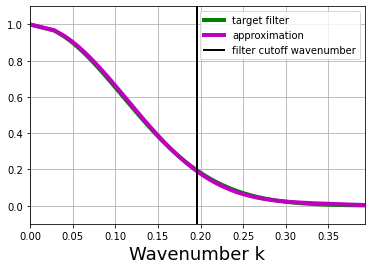

In [34]:
filter_t.plot_shape()

#### Filter averages

In [ ]:
namelist = ['eta', 'eta2', 'deta_dt', 'deta2_dt', 'hKE', 'MP', 'PE_to_KE+KE_BT', 'uhM_div'   # both
            'h',  # Lorenz
            'dhdt' # extended
            
    'h','hKE','dKE_dt','KE_CorAdv','KE_adv','PE_to_KE+KE_BT','KE_horvisc','KE_visc','KE_stress',
            
            
#namelist = ['h','hKE','dKE_dt','KE_CorAdv','KE_adv','PE_to_KE+KE_BT','KE_horvisc','KE_visc','KE_stress','etaB','dhdt']

for name in namelist:
    field = av[name]
    if gpu:
        field.data = field.data.map_blocks(cp.asarray)        
    field_filtered = filter_t.apply(field, dims=['yh', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    av_f[name] = field_filtered.where(st.wet)           

    av_f[name].attrs = av[name].attrs
    av_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

#### Filter snapshots

In [ ]:
namelist = ['h','hKE',  # Lorenz
            
            'eta2']

for name in namelist:
    field = sn[name]
    if gpu:
        field.data = field.data.map_blocks(cp.asarray)        
    field_filtered = filter_t.apply(field, dims=['yh', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    sn_f[name] = field_filtered.where(st.wet)           

    sn_f[name].attrs = sn[name].attrs
    sn_f[name].attrs['long_name'] = 'Filtered ' + sn[name].attrs['long_name']

## U-fields

In [ ]:
wet_mask = st.wet_u.isel(xq=slice(1,None))
area = st.area_u.isel(xq=slice(1,None))
if gpu:
    wet_mask = wet_mask.chunk({'yh': Ny,'xq': Nx}) # 1 chunk
    wet_mask.data = wet_mask.data.map_blocks(cp.asarray)

    area = area.chunk({'yh': Ny,'xq': Nx}) # 1 chunk
    area.data = area.data.map_blocks(cp.asarray)

In [ ]:
filter_u = gcm_filters.Filter(
        filter_scale=filter_fac,
        dx_min=1,
        n_iterations=n_iterations,
        filter_shape=filter_shape,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )  
filter_u

#### Filter averages

In [ ]:
namelist = ['u', 'du_dt_str_visc_rem', 'uh', 'h_du_dt_str']
namelist = ['u','CAu_visc_rem','PFu+u_BT_accel_visc_rem','diffu_visc_rem','uh','uhp','du_dt_visc_rem','du_dt_str_visc_rem']
namelist = ['h_CAu','h_PFu+u_BT_accel','h_diffu','h_du_dt_visc', 'h_du_dt', 'h_du_dt_str', 'duhdt']

namelist = ['u', 'PFu+u_BT_accel_visc_rem',  # Lorenz

            'uh' # both
for name in namelist:
    field = av[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_u.apply(field, dims=['yh', 'xq'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    av_f_tmp[name] = field_filtered 
    av_f_tmp[name] = av_f_tmp[name].transpose('time', 'zl', 'yh', 'xq') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the western edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        av_f[name] = av_f_tmp[name]
    av_f[name] = xr.where(av_f.xq==av_f.xq[0], av_f[name].roll(xq=1,roll_coords=False), av_f[name])
    av_f[name] = av_f[name].where(st.wet_u)
    av_f[name] = av_f[name].transpose('time', 'zl', 'yh', 'xq')

    av_f[name].attrs = av[name].attrs
    av_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

#### Filter snapshots

In [ ]:
namelist = ['u' # Lorenz
    
    'uh',
            ]

for name in namelist:
    field = sn[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_u.apply(field, dims=['yh', 'xq'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    sn_f_tmp[name] = field_filtered 
    sn_f_tmp[name] = sn_f_tmp[name].transpose('time', 'zl', 'yh', 'xq') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the western edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        sn_f[name] = sn_f_tmp[name]
    sn_f[name] = xr.where(sn_f.xq==sn_f.xq[0], sn_f[name].roll(xq=1,roll_coords=False), sn_f[name])
    sn_f[name] = sn_f[name].where(st.wet_u)
    sn_f[name] = sn_f[name].transpose('time', 'zl', 'yh', 'xq')

    sn_f[name].attrs = sn[name].attrs
    sn_f[name].attrs['long_name'] = 'Filtered ' + sn[name].attrs['long_name']

## V-fields

In [18]:
wet_mask = st.wet_v.isel(yq=slice(1,None))
area = st.area_v.isel(yq=slice(1,None))
if gpu:
    wet_mask = wet_mask.chunk({'yq': Ny,'xh': Nx}) # 1 chunk
    wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
    
    area = area.chunk({'yq': Ny,'xh': Nx}) # 1 chunk
    area.data = area.data.map_blocks(cp.asarray)

In [19]:
filter_v = gcm_filters.Filter(
        filter_scale=filter_fac,
        dx_min=1,
        n_iterations=n_iterations,
        filter_shape=filter_shape,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )    
filter_v

Filter(filter_scale=32.0, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=36, n_iterations=1, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

#### Filter averages

In [20]:
namelist = ['v', 'dv_dt_str_visc_rem', 'vh', 'h_dv_dt_str']
namelist = ['v','CAv_visc_rem','PFv+v_BT_accel_visc_rem','diffv_visc_rem','vh','vhp','dv_dt_visc_rem','dv_dt_str_visc_rem']   
namelist = ['h_CAv','h_PFv+v_BT_accel','h_diffv','h_dv_dt_visc', 'h_dv_dt', 'h_dv_dt_str', 'dvhdt']

namelist = ['v', 'PFv+v_BT_accel_visc_rem',  # Lorenz
            'vh' # both
for name in namelist:
    field = av[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_v.apply(field, dims=['yq', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    av_f_tmp[name] = field_filtered  
    av_f_tmp[name] = av_f_tmp[name].transpose('time', 'zl', 'yq', 'xh') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the southern edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        av_f[name] = av_f_tmp[name]

    # set yq = 0 to nan's (all land):        
    av_f[name] = xr.where(av_f.yq==av_f.yq[0], np.nan, av_f[name])
    av_f[name] = av_f[name].where(st.wet_v)
    av_f[name] = av_f[name].transpose('time', 'zl', 'yq', 'xh')

    av_f[name].attrs = av[name].attrs
    av_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,


#### Filter snapshots

In [ ]:
namelist = ['v'  # Lorenz
    
    'vh','v']

for name in namelist:
    field = sn[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_v.apply(field, dims=['yq', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    sn_f_tmp[name] = field_filtered  
    sn_f_tmp[name] = sn_f_tmp[name].transpose('time', 'zl', 'yq', 'xh') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the southern edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        sn_f[name] = sn_f_tmp[name]

    # set yq = 0 to nan's (all land):        
    sn_f[name] = xr.where(sn_f.yq==sn_f.yq[0], np.nan, sn_f[name])
    sn_f[name] = sn_f[name].where(st.wet_v)
    sn_f[name] = sn_f[name].transpose('time', 'zl', 'yq', 'xh')

    sn_f[name].attrs = sn[name].attrs
    sn_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

## Save filtered fields

In [ ]:
path = '/glade/scratch/noraloose/filtered_data'
ffile_f_av = '%s/%s/averages_%08d_filtered_fac%i' %(path, run, end_time-nr_days+2, filter_fac) 
ffile_f_sn = '%s/%s/snapshots_%08d_filtered_fac%i' %(path, run, end_time-nr_days+5, filter_fac) 

In [55]:
av_f

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [ ]:
if step == 1:
    ds1.to_zarr(ffile_f + '_h')
elif step == 2:
    ds1.to_zarr(ffile_f + '_u')    
elif step == 3:
    ds1.to_zarr(ffile_f + '_v') 

In [ ]:
if step == 1:
    ds2.to_zarr(ffile_f_sn + '_h')
elif step == 2:
    ds2.to_zarr(ffile_f_sn + '_u')    
elif step == 3:
    ds2.to_zarr(ffile_f_sn + '_v')    
